# Read MNIST dataset

Dataset downloaded from *https://www.garrickorchard.com/datasets/n-mnist*

event-Python repo downloaded from github: *https://github.com/gorchard/event-Python*

In [1]:
import sys
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('event-Python')

import eventvision

Event-based vision module imported


In [2]:
ev = eventvision.read_dataset(r'datasets\mnist\Test\0\00004.bin')

In [6]:
ev.show_td(100)

In [7]:
ev.data

rec.array([(18, 11, False,    581), (21, 13, False,   1703),
           (12, 24, False,   2625), ..., (21, 19,  True, 307025),
           (32, 10,  True, 307397), (10, 19,  True, 308529)],
          dtype=[('x', '<u2'), ('y', '<u2'), ('p', '?'), ('ts', '<u8')])

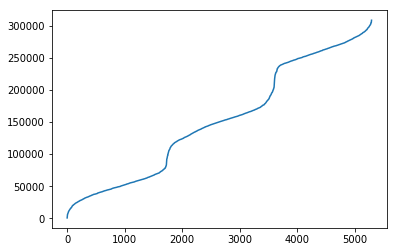

In [6]:
plt.plot([v.ts for v in ev.data])

In [8]:
# plt.plot([v.p * 1 for v in ev.data])
for i in range(100):
    print ev.data[i].p

False
False
False
False
True
False
True
True
False
False
True
False
True
False
False
False
False
False
False
True
False
True
False
True
False
False
False
False
True
True
False
False
False
False
False
False
True
False
False
False
False
False
True
True
False
False
False
False
True
True
False
False
True
False
False
True
True
False
False
True
False
False
False
False
True
False
False
True
False
True
False
False
True
True
True
True
True
False
False
True
True
True
True
False
False
False
True
False
True
True
True
False
True
False
False
True
False
False
False
False


In [9]:
len([1 for v in ev.data if not v.p])

2704

## Plot time context $\mathcal{T}_i(\mathbf{u},p)$ and time surface $\mathcal{S}_i(\mathbf{u},p)$

The time context is a 3D (2 spatial axes and 1 time) surface that indicates the most recent activations/events for each pixel at a given moment in time $i$ , within a small spatial region $\mathbf{u}$:

$$\mathcal{T}_i(\mathbf{u},p) = max_{j <= i}\{t_j | \mathbf{x}_j = (\mathbf{x}_i + \mathbf{u}), p_j = p\}$$

Note that we choose to either plot ON ($p_j = 1$) or OFF ($p_j = -1$) events, not both at the same time, just to aid visualisation.

This time-context operation is essentially a form of spatio-temporal max-pooling.


The time surface is the time context with an exponential decay applied:

$$\mathcal{S}_i(\mathbf{u},p) = e^{-(t_i - \mathcal{T}_i(\mathbf{u},p) )/\tau} $$


In [47]:
class Feature(object):
    def __init__(self, height, width, region_size, time_constant):
        self.height = height
        self.width = width

        self.latest_times_on = np.zeros((self.height, self.width))
        self.latest_times_off = np.zeros_like(self.latest_times_on)

        self.time_context_on = np.zeros_like(self.latest_times_on)
        self.time_context_off = np.zeros_like(self.latest_times_on)

        self.time_surface_on = np.zeros_like(self.latest_times_on)
        self.time_surface_off = np.zeros_like(self.latest_times_on)

        self.r = region_size
        self.time_constant = time_constant

    def _update_latest_times(self, event):
        """ create grid showing latest times at each spatial coordinate """

        if event.p:
            self.latest_times_on[event.y, event.x] = event.ts
        else:
            self.latest_times_off[event.y, event.x] = event.ts

    def _update_time_context(self, event_on):
        """ create time context from grid of latest times """

        for x in range(self.width):
            for y in range(self.height):
                if self.r <= x and self.r <= y:
                    if event_on:
                        self.time_context_on[y, x] = \
                            np.max(self.latest_times_on[y - self.r:y + self.r, x - self.r:x + self.r])
                    else:
                        self.time_context_off[y, x] = \
                            np.max(self.latest_times_off[y - self.r:y + self.r, x - self.r:x + self.r])

    def _update_time_surface(self, event_on, current_time):
        """ create time surface from time context """

        if event_on:
            self.time_surface_on = np.exp(-(current_time - self.time_context_on) / self.time_constant)
        else:
            self.time_surface_off = np.exp(-(current_time - self.time_context_off) / self.time_constant)

    def process_event(self, event):
        """ update the latest times grid, time context and time surface uon receiving a new event """

        self._update_latest_times(event)
        self._update_time_context(event.p)
        self._update_time_surface(event.p, event.ts)

In [52]:
feat.time_surface_on.shape

(34L, 34L)

1 loop, best of 3: 39.6 s per loop


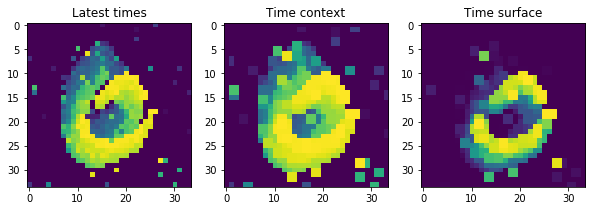

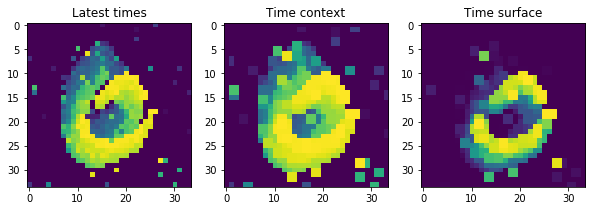

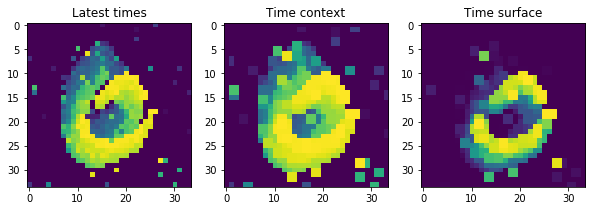

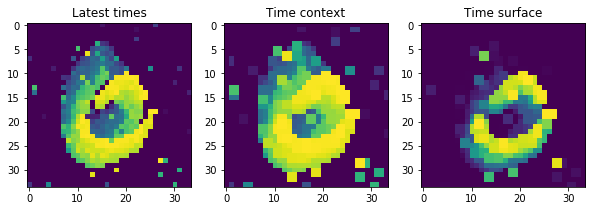

In [48]:
%%timeit

# plot time context

feat = Feature(ev.height, ev.width, region_size=1, time_constant=10000*2)

# set time to pause at
t_pause = 170000

for e in ev.data:
    if e.ts <= t_pause:
        feat.process_event(e)
            
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(feat.latest_times_on)
ax[1].imshow(feat.time_context_on)
ax[2].imshow(feat.time_surface_on)
ax[0].set_title('Latest times')
ax[1].set_title('Time context')
ax[2].set_title('Time surface')

## Initialise time surface prototypes

In [ ]:
# Choose number of prototypes for layer 1
N_1 = 10

# initialis each of the time surface prototypes

for i in range(N_1):
    